In [1]:
import pandas as pd

# CSV 파일 경로 설정
csv_file_path = 'cascade_rcnn_swinL_aug2.csv'

classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]


df = pd.read_csv(csv_file_path)
rows = []

# 각 이미지에 대한 bbox 정보 파싱
for index, row in df.iterrows():
    # PredictionString이 NaN이 아닐 경우에만 처리
    if pd.notna(row['PredictionString']):
        predictions = row['PredictionString'].strip().split(' ')
        image_id = row['image_id']

        # 각 bbox를 추출하여 행 추가
        for i in range(0, len(predictions), 6):
            if i + 5 < len(predictions):
                class_id = int(predictions[i])
                class_name = classes[class_id]
                confidence = float(predictions[i + 1])
                x1 = float(predictions[i + 2])
                y1 = float(predictions[i + 3])
                x2 = float(predictions[i + 4])
                y2 = float(predictions[i + 5])
                rows.append([image_id, class_id, class_name, confidence, x1, x2, y1, y2])

# 새로운 DataFrame 생성
columns = ['image_id', 'class_id', 'class_name', 'confidence', 'x_min', 'y_min', 'x_max', 'y_max']
bbox_pred = pd.DataFrame(rows, columns=columns)

# 결과 출력
bbox_pred


,image_id,class_id,class_name,confidence,x_min,y_min,x_max,y_max
0,test/0000.jpg,7,Plastic bag,0.9997,215.43,454.37,51.31,478.49
1,test/0000.jpg,7,Plastic bag,0.9994,119.47,329.02,423.13,721.43
2,test/0000.jpg,7,Plastic bag,0.9994,605.92,943.47,517.94,1022.80
3,test/0000.jpg,7,Plastic bag,0.9986,390.48,596.87,191.06,544.47
4,test/0000.jpg,5,Plastic,0.9983,244.44,300.26,682.14,749.79
...,...,...,...,...,...,...,...,...
59685,test/4869.jpg,1,Paper,0.0736,874.78,898.90,1.59,123.52
59686,test/4869.jpg,0,General trash,0.0722,833.65,1021.34,0.00,580.52
59687,test/4869.jpg,1,Paper,0.0686,886.81,1024.00,4.41,109.39
59688,test/4869.jpg,5,Plastic,0.0561,12.04,277.07,0.00,302.99


In [2]:
# test 파일 개수 확인 = 4871
len(df)

4871

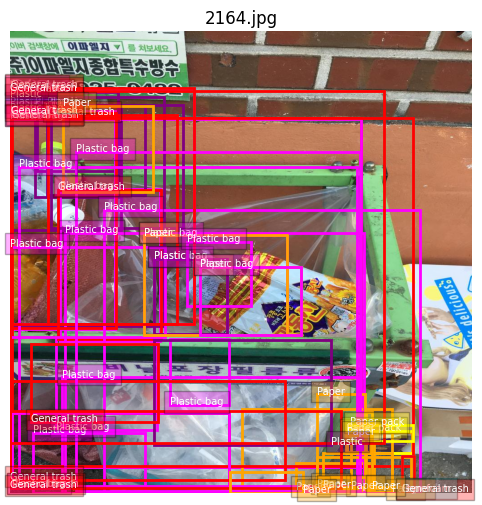

Image ID: test/2164.jpg
Bbox 개수: 55


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import os

# 데이터셋 경로 설정
BASE_DIR = './dataset'

# 바운딩 박스 색상 설정 (클래스명에 따라)
class_colors = {
    "General trash": "red", 
    "Paper": "orange", 
    "Paper pack": "yellow", 
    "Metal": "green", 
    "Glass": "blue", 
    "Plastic": "purple", 
    "Styrofoam": "cyan", 
    "Plastic bag": "magenta", 
    "Battery": "pink", 
}

# bbox를 포함하는 sample
def plot_sample_with_bbox(image_path, bbox):
    # 이미지 로드
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 이미지 표시
    ax.imshow(img)
    ax.axis('off')
    
    # Bbox 그리기
    for _bbox_info in bbox:
        x, y, w, h, class_name = _bbox_info
        color = class_colors.get(class_name, 'yellow')  # 기본 색상은 노란색
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"{class_name}", fontsize=7, color='white', bbox=dict(facecolor=color, alpha=0.3))

    plt.title(os.path.basename(image_path), loc='center', pad=5)
    plt.axis('off')
    plt.show()
    
# bbox anchor을 coco 형태로 재구성
def bbox_anchor(Dataframe):
    # x, y, w, h
    bbox_anchor_info = [Dataframe['x_min'], 
                        Dataframe['y_min'], 
                        Dataframe['x_max'] - Dataframe['x_min'], 
                        Dataframe['y_max'] - Dataframe['y_min']]
    
    return bbox_anchor_info

# 데이터셋에서 랜덤하게 샘플 선택
sample_index = random.randint(0, len(bbox_pred) - 1)
sample_row = bbox_pred.iloc[sample_index]

# 이미지 경로와 Bbox 정보 추출
image_path = os.path.join(BASE_DIR, sample_row['image_id'])
sample_img_df = bbox_pred[bbox_pred['image_id'] == sample_row['image_id']]

# 해당 sample의 모든 bbox anchor
bbox_set = []

for idx in range(len(sample_img_df)):
    bbox_info = bbox_anchor(sample_img_df.iloc[idx])
    class_name = sample_img_df.iloc[idx]['class_name']
    bbox_set.append((*bbox_info, class_name))

# 샘플 이미지와 Bbox 표시
plot_sample_with_bbox(image_path, bbox_set)

print(f"Image ID: {sample_row['image_id']}")
print(f"Bbox 개수: {len(bbox_set)}")


In [4]:
# 샘플 이미지 정보 출력
print(f"Sample Row: {sample_row}")

# 샘플 이미지 DataFrame 확인
print("Sample Image DataFrame:")
sample_img_df


Sample Row: image_id      test/2164.jpg
class_id                  1
class_name            Paper
confidence           0.3008
x_min                867.62
y_min               1021.29
x_max                895.59
y_max                943.03
Name: 25993, dtype: object
Sample Image DataFrame:


,image_id,class_id,class_name,confidence,x_min,y_min,x_max,y_max
25973,test/2164.jpg,5,Plastic,0.9894,0.00,164.53,245.24,442.13
25974,test/2164.jpg,5,Plastic,0.9863,55.15,163.80,242.14,367.17
25975,test/2164.jpg,7,Plastic bag,0.9771,101.51,883.65,324.66,681.74
25976,test/2164.jpg,1,Paper,0.9476,756.00,1014.78,805.55,908.66
25977,test/2164.jpg,7,Plastic bag,0.9438,115.85,767.68,773.21,1024.00
25978,test/2164.jpg,7,Plastic bag,0.8852,353.50,828.92,483.84,682.33
25979,test/2164.jpg,7,Plastic bag,0.7665,0.00,127.65,407.77,650.16
25980,test/2164.jpg,0,General trash,0.7383,0.00,192.83,778.27,966.29
25981,test/2164.jpg,7,Plastic bag,0.7180,110.35,349.16,332.57,687.54
25982,test/2164.jpg,7,Plastic bag,0.6488,0.00,194.13,778.40,966.00


In [5]:
import pandas as pd

# CSV 파일 경로 설정
csv_file_path = 'cascade_rcnn_no_aug.csv'

# CSV 파일 읽기
df = pd.read_csv(csv_file_path)

# NaN 값이 있는 열과 그 개수 출력
nan_summary = df.isna().sum()
print(nan_summary[nan_summary > 0])

# 특정 열에서 NaN 값이 있는 행 출력 (예: 'PredictionString' 열) ==> bbox 없음
nan_rows = df[df['PredictionString'].isna()]
print(nan_rows)


PredictionString    19
dtype: int64
     PredictionString       image_id
34                NaN  test/0034.jpg
730               NaN  test/0730.jpg
1208              NaN  test/1208.jpg
1291              NaN  test/1291.jpg
1396              NaN  test/1396.jpg
1474              NaN  test/1474.jpg
1497              NaN  test/1497.jpg
1528              NaN  test/1528.jpg
2081              NaN  test/2081.jpg
2150              NaN  test/2150.jpg
2352              NaN  test/2352.jpg
2816              NaN  test/2816.jpg
2983              NaN  test/2983.jpg
3165              NaN  test/3165.jpg
3368              NaN  test/3368.jpg
3390              NaN  test/3390.jpg
3741              NaN  test/3741.jpg
4757              NaN  test/4757.jpg
4787              NaN  test/4787.jpg


In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 데이터셋 경로 설정
BASE_DIR = './dataset'
OUTPUT_DIR = './submission_bbox'  # 결과 저장할 경로

# 결과 저장 디렉토리 생성
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 바운딩 박스 색상 설정 (클래스명에 따라)
class_colors = {
    "General trash": "red", 
    "Paper": "orange", 
    "Paper pack": "yellow", 
    "Metal": "green", 
    "Glass": "blue", 
    "Plastic": "purple", 
    "Styrofoam": "cyan", 
    "Plastic bag": "magenta", 
    "Battery": "pink", 
    "Clothing": "brown"
}

# bbox anchor을 coco 형태로 재구성
def bbox_anchor(Dataframe):
    # x, y, w, h
    bbox_anchor_info = [
        Dataframe['x_min'], 
        Dataframe['y_min'], 
        Dataframe['x_max'] - Dataframe['x_min'], 
        Dataframe['y_max'] - Dataframe['y_min']
    ]
    return bbox_anchor_info

# 이미지 ID에서 숫자 부분 추출
def extract_image_id(image_id):
    return int(os.path.splitext(os.path.basename(image_id))[0])

# 모든 이미지에 bbox 적용
def save_images_with_bbox(dataframe):
    for image_id in dataframe['image_id'].unique():
        # 특정 이미지 ID부터 시작
        if extract_image_id(image_id) < 3018:
            continue

        image_path = os.path.join(BASE_DIR, image_id)
        sample_img_df = dataframe[dataframe['image_id'] == image_id]

        # 이미지 로드
        img = Image.open(image_path)
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img)
        ax.axis('off')

        # 해당 sample의 모든 bbox anchor
        bbox_set = []

        for idx in range(len(sample_img_df)):
            bbox_info = bbox_anchor(sample_img_df.iloc[idx])
            class_name = sample_img_df.iloc[idx]['class_name']
            bbox_set.append((*bbox_info, class_name, id))

            # Bbox 색상 설정
            color = class_colors.get(class_name, 'yellow')  # 기본 색상은 노란색

            # Bbox 그리기
            x, y, w, h = bbox_info
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y, f"{class_name} (ID : {id})", fontsize=7, color='white', bbox=dict(facecolor=color, alpha=0.4))

        # 이미지 제목 추가
        plt.title(os.path.basename(image_path), loc='center', pad=5)
        
        # JPG 파일로 저장
        output_image_path = os.path.join(OUTPUT_DIR, os.path.splitext(image_id)[0][-4:] + '_bbox.jpg')
        plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
        plt.close(fig)  # 메모리 절약을 위해 닫기

# 모든 이미지에 바운딩 박스를 그려서 저장
save_images_with_bbox(bbox_pred)

print(f"All images with bounding boxes have been saved to {OUTPUT_DIR}.")


All images with bounding boxes have been saved to ./submission_bbox.
